# ML forecasting

The goal is to forecast the next period's GDP growth (in real 2015 US dollars), therefore all explanatory variables are lagged by one period (one year)

GDP growth two-year lagged is also included to account for any potential autorregresive aspects

In [1]:
#!pip install numpy==1.20.0 --user
#!pip install xgboost tensorflow keras plotly pycountry pycountry_convert jupyterthemes bioinfokit spicy bayesian-optimization pydot graphviz shap
#!pip install sklearn --upgrade --user

In [1]:
import pandas as pd
import numpy as np

import pycountry, pycountry_convert

import seaborn as sns




from sklearn.linear_model import ElasticNet

# KNN regression
from sklearn.neighbors import KNeighborsRegressor, KernelDensity, KDTree

# XGBoost
import xgboost as xgb

# Neural Networks regression
from tensorflow.keras import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.layers import Dense, Dropout, LSTM, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
import tensorflow as tf
from tensorflow.keras.utils import plot_model
tf.compat.v1.disable_eager_execution()
from bayes_opt import BayesianOptimization
import warnings
warnings.filterwarnings('ignore')

# Walking window CV:
from sklearn.model_selection._split import TimeSeriesSplit


from math import sqrt, log, exp, floor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold, RandomizedSearchCV, GridSearchCV, cross_validate, cross_val_predict
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error # for error reporting
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import matplotlib
import statsmodels.api as sm
matplotlib.style.use('seaborn')

C:\Users\ncozz\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


---------------
## Data imputation

Now we move to actually building the ML models; for this, we first do basic data imputation

Population and total GDP are converted to logarithmic scale

For filling missing values, the following approach is considered:
* First, forward fill then backfill is done per variable, per country
* Second, the median value is considered for income level, continent and year groups, per variable
* Third, the median value is considered for income level and continent groups, per variable
* Finally, the median value is considered for income group, per variable

No further approaches are needed for remaining missing values (KNN imputation, etcetera)


In [96]:
gdp_df_final = pd.read_csv('data/gdp_df_final.csv')
errors_fc_1F = pd.read_csv('data/errors_fc_1F.csv')
errors_fc_1S = pd.read_csv('data/errors_fc_1S.csv')

In [5]:
pd.set_option("display.max_rows", 20)
gdp_df_final = gdp_df_final.sort_values(by=['Year','ISO3'],ascending=True)


url = 'https://databank.worldbank.org/data/download/site-content/CLASS.xlsx'
classifications = pd.ExcelFile(url)
classifications = pd.read_excel(url, sheet_name="List of economies", header= 0)
classifications

classifications = classifications[['Code', 'Income group']]
classifications.columns = classifications.columns.str.replace('Code', 'ISO3')

continents = []
for iso3 in gdp_df_final.ISO3:
    try:
        continents = continents + [pycountry_convert.country_alpha2_to_continent_code(pycountry_convert.country_alpha3_to_country_alpha2(iso3))]
    except:
        continents = continents + ['OTHER']
        
gdp_df_final.insert(0, 'continent_code', continents, 'continent_code')
gdp_df_final = gdp_df_final.merge(classifications[['ISO3','Income group']], how='left')
gdp_df_final.columns = gdp_df_final.columns.str.replace('Income group', 'income_group')
gdp_df_final = gdp_df_final[['income_group'] + [col for col in gdp_df_final.columns if col != 'income_group']]

In [6]:
gdp_df_final.head()

,income_group,continent_code,ISO3,Year,gdp_real_gwt_next,gdp_real_gwt_prev,gdp_real_gwt,gdp_real_us_fixed,gdp_per_capita,gdp_pp_govt,...,agric_land,agff_gdp,arable_land,rural_pop,electricity_access,fuel_exports,metal_exports,co2_emissions,industry_gdp,service_value_added
0,Lower middle income,AF,AGO,2001,13.665689,3.054624,4.205999,3.130593e+10,1847.420229,25.154633,...,38.113781,8.156377,2.406353,48.726,20.000000,NaN,NaN,0.941829,64.883812,NaN
1,Upper middle income,EU,ALB,2001,4.536524,6.946217,8.293313,6.559561e+09,2143.526278,10.625955,...,41.569343,22.716164,21.094891,57.565,100.000000,1.448359,2.912995,1.055496,21.735774,8155.197477
2,Upper middle income,SA,ARG,2001,-10.894485,-0.788999,-4.408840,3.782027e+11,10146.106818,14.156274,...,46.993266,4.568590,10.138525,10.671,95.511063,17.027214,3.052707,3.360371,25.243434,19949.805642
3,Upper middle income,AS,ARM,2001,13.200000,5.900000,9.600000,4.339530e+09,1422.476654,10.341338,...,46.645592,NaN,15.981735,35.615,100.000000,7.869125,27.424558,1.180062,NaN,3946.029390
4,High income,NA,ATG,2001,1.027442,6.203431,-4.548003,1.020746e+09,13220.044832,19.474390,...,20.454545,1.613381,9.090909,68.260,97.785255,NaN,NaN,4.532974,12.882524,NaN


In [7]:
# missing values per column
pd.set_option("display.max_rows", None)
gdp_df_final.isna().sum(0)

income_group                 0
continent_code               0
ISO3                         0
Year                         0
gdp_real_gwt_next            0
gdp_real_gwt_prev            0
gdp_real_gwt                 0
gdp_real_us_fixed            0
gdp_per_capita               0
gdp_pp_govt                134
gdp_pp_private             134
inflation_pp                 0
unemployment               851
renew_energy               139
agric_employment           196
vulnerable_employment      196
imports                     99
exports                     99
foreign_inv                  1
real_interest_rate         813
cab                         82
population                   0
pop_density                  0
pop_growth                   0
life_expectancy             19
death_rate                  15
child_mortality             20
renewable_energy_output    691
agric_land                   0
agff_gdp                    25
arable_land                  0
rural_pop                    0
electric

In [8]:
pd.set_option("display.max_rows", 20)

In [9]:
# feature engineering
gdp_df_final['log_gdp_real_us_fixed'] = np.log(gdp_df_final['gdp_real_us_fixed'])
log_gdp_values = gdp_df_final['log_gdp_real_us_fixed'].values # stored for assigning ml_weights later
gdp_df_final['log_population'] = np.log(gdp_df_final['population'])
gdp_df_final['gdp_per_capita'] = np.exp(gdp_df_final['log_gdp_real_us_fixed'] - gdp_df_final['log_population'])
gdp_df_final = gdp_df_final.drop(columns=['gdp_real_us_fixed','population'], inplace=False)

In [10]:
col_group = 'ISO3'

list_cols = gdp_df_final.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index
for colname in list_cols:
    gdp_df_final[colname] = gdp_df_final.groupby(col_group, sort=False)[colname].transform(lambda x: x.ffill().bfill())

In [11]:
# columns with remaining NA
gdp_df_final.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index

Index(['agric_employment', 'vulnerable_employment', 'real_interest_rate',
       'child_mortality', 'fuel_exports', 'metal_exports', 'co2_emissions',
       'service_value_added'],
      dtype='object')

In [12]:
col_group = ['income_group','continent_code','Year']

list_cols = gdp_df_final.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index
for colname in list_cols:
    gdp_df_final[colname] = gdp_df_final.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))

In [13]:
col_group = ['income_group','continent_code']

list_cols = gdp_df_final.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index
for colname in list_cols:
    gdp_df_final[colname] = gdp_df_final.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))

In [14]:
col_group = ['income_group']

list_cols = gdp_df_final.isna().sum(0)[gdp_df_final.isna().sum(0)>0].index
for colname in list_cols:
    gdp_df_final[colname] = gdp_df_final.groupby(col_group, sort=False)[colname].transform(lambda x: x.fillna(x.median()))

In [15]:
# columns with remaining NA
pd.set_option("display.max_rows", None)
gdp_df_final.isna().sum(0)

income_group               0
continent_code             0
ISO3                       0
Year                       0
gdp_real_gwt_next          0
gdp_real_gwt_prev          0
gdp_real_gwt               0
gdp_per_capita             0
gdp_pp_govt                0
gdp_pp_private             0
inflation_pp               0
unemployment               0
renew_energy               0
agric_employment           0
vulnerable_employment      0
imports                    0
exports                    0
foreign_inv                0
real_interest_rate         0
cab                        0
pop_density                0
pop_growth                 0
life_expectancy            0
death_rate                 0
child_mortality            0
renewable_energy_output    0
agric_land                 0
agff_gdp                   0
arable_land                0
rural_pop                  0
electricity_access         0
fuel_exports               0
metal_exports              0
co2_emissions              0
industry_gdp  

In [16]:
pd.set_option("display.max_rows", 20)

In [17]:
index_target = gdp_df_final.columns.get_loc("gdp_real_gwt_next")

# standardizing variables:
for df in [gdp_df_final]:
    df.iloc[:,index_target:] = StandardScaler().fit_transform(df.iloc[:,index_target:])

In [18]:
x_train = gdp_df_final.iloc[:,(index_target+1):]
y_train = gdp_df_final.gdp_real_gwt_next

In [19]:
x_train.columns

Index(['gdp_real_gwt_prev', 'gdp_real_gwt', 'gdp_per_capita', 'gdp_pp_govt',
       'gdp_pp_private', 'inflation_pp', 'unemployment', 'renew_energy',
       'agric_employment', 'vulnerable_employment', 'imports', 'exports',
       'foreign_inv', 'real_interest_rate', 'cab', 'pop_density', 'pop_growth',
       'life_expectancy', 'death_rate', 'child_mortality',
       'renewable_energy_output', 'agric_land', 'agff_gdp', 'arable_land',
       'rural_pop', 'electricity_access', 'fuel_exports', 'metal_exports',
       'co2_emissions', 'industry_gdp', 'service_value_added',
       'log_gdp_real_us_fixed', 'log_population'],
      dtype='object')

----------------------------------------
## Training models:
### We first define the weights for training models:

Slightly higher weights are assigned to countries with higher total GDP - the log-scale is set; otherwise, disproportionate weights would be caused by the largest economies, rendering smaller ones as insignificant for the training of ML models

In [20]:
# ml_weights = np.log(gdp_df_final.loc[x_train.index.tolist(),'gdp_per_capita'])
ml_weights = log_gdp_values

In [21]:
log_gdp_values

array([24.16707327, 22.60418955, 26.65869604, ..., 20.521764  ,
       26.53930544, 23.87681118])

Text(0.5, 0, 'log_gdp_real_us_fixed')

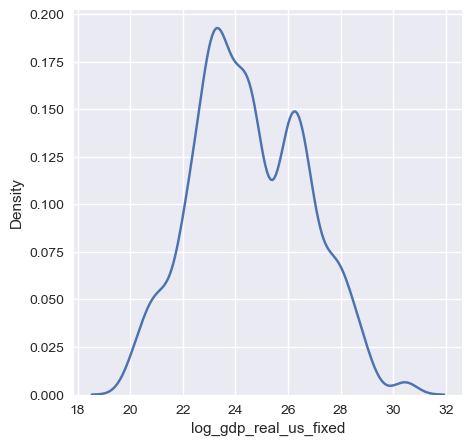

In [22]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(ml_weights)
plt.xlabel('log_gdp_real_us_fixed')

Text(0.5, 0, 'gdp_real_us_fixed')

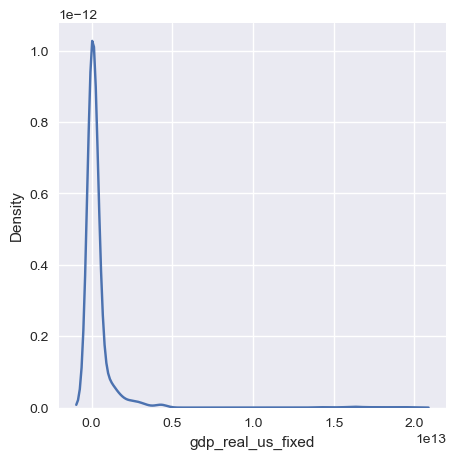

In [23]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(np.exp(ml_weights))
plt.xlabel('gdp_real_us_fixed')

### Defining walking forward CV:

Since we are dealing with longitudinal data, neither a train-test split nor N-fold CV approaches for validating models are suitable - there usually is serial correlation involved in the dataset, plus a knowledge-gaining process over time that is ignored by these two methodologies

What we attempt instead is walk-forward crossvalidation, which consists of the following:
* The first training set is the first period (year) of observations, and the first testing set is the second year
* The second training set includes the first two years, and the second testing set includes the year following (third year)
* Training sets iteratively include the following period, and testing sets iteratively include the period after the last one of the training set
* This is done until the last year is used as validation set, mimicking the information gain process of time series and of longitudinal data

Source: https://robjhyndman.com/hyndsight/tscv/

In [24]:
n_years = int(len(gdp_df_final) / len(gdp_df_final.ISO3.unique())) - 1
tscv = TimeSeriesSplit(n_splits=n_years)

------------------
### Random forest regression:

For this algorithm, random search then gridsearch (with a smaller range) plus time series CV (TSCV) is implemented for hyperparameter tuning

In [33]:
# Cross-validation and hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 5)]
# Criterion selection
criterion = ['mse']
# Number of features to consider at every split
max_features = [1/3,'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [0.01,0.02,1]
# Minimum number of samples required at each leaf node
min_samples_leaf = [0.01,0.02,1]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
from datetime import datetime
startTime = datetime.now()

rf_regressor = RandomForestRegressor(random_state = 777, n_jobs = 3)
rf_random = RandomizedSearchCV(estimator = rf_regressor,
                               param_distributions = param_grid,
                               n_iter=100, cv = tscv,
                               scoring='neg_mean_absolute_error',
                                random_state=777)
rf_random.fit(x_train.values, y_train.values, sample_weight= ml_weights)

print(datetime.now() - startTime)

0:31:02.021562


In [35]:
print('MAE: %.3f' % rf_random.best_score_)
print('Config: %s' % rf_random.best_params_)

MAE: -0.570
Config: {'n_estimators': 1500, 'min_samples_split': 0.02, 'min_samples_leaf': 0.02, 'max_features': 0.3333333333333333, 'max_depth': 10, 'criterion': 'mse', 'bootstrap': True}


In [36]:
from datetime import datetime
startTime = datetime.now()

rf_regressor = RandomForestRegressor(random_state = 777, n_jobs = 3)

# grid (updated iteratively)
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 1500, num = 5)]
criterion = ['mse']
max_features = ['sqrt',1/3]
max_depth = [10,20] #[int(x) for x in np.linspace(20, 40, num = 3)]
min_samples_split = [0.02,1]
min_samples_leaf = [0.02,1]
bootstrap = [True]


# Create the random grid
param_grid2 = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'random_state': [777]}



rf_grid = GridSearchCV(estimator = rf_regressor,
                                param_grid = param_grid2,
                                scoring='neg_mean_absolute_error',
                                cv = tscv)
rf_grid.fit(x_train.values, y_train.values, sample_weight= ml_weights)

print(datetime.now() - startTime)

1:20:53.107844


In [37]:
print('MAE: %.3f' % rf_grid.best_score_)
print('Config: %s' % rf_grid.best_params_)

MAE: -0.570
Config: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 10, 'max_features': 0.3333333333333333, 'min_samples_leaf': 0.02, 'min_samples_split': 0.02, 'n_estimators': 1500, 'random_state': 777}


In [38]:
rf_regressor = RandomForestRegressor(bootstrap= True,random_state = 777)
rf_regressor.set_params(**rf_grid.best_params_)

RandomForestRegressor(criterion='mse', max_depth=10,
                      max_features=0.3333333333333333, min_samples_leaf=0.02,
                      min_samples_split=0.02, n_estimators=1500,
                      random_state=777)

In [39]:
rf_regressor.fit(x_train, y_train, sample_weight= ml_weights)

RandomForestRegressor(criterion='mse', max_depth=10,
                      max_features=0.3333333333333333, min_samples_leaf=0.02,
                      min_samples_split=0.02, n_estimators=1500,
                      random_state=777)

In [40]:
y_model = rf_regressor.predict(x_train)  

In [41]:
cross_val_score(rf_regressor, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5703072195507737

In [42]:
cross_val_score(rf_regressor, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8019787952106355

<BarContainer object of 33 artists>

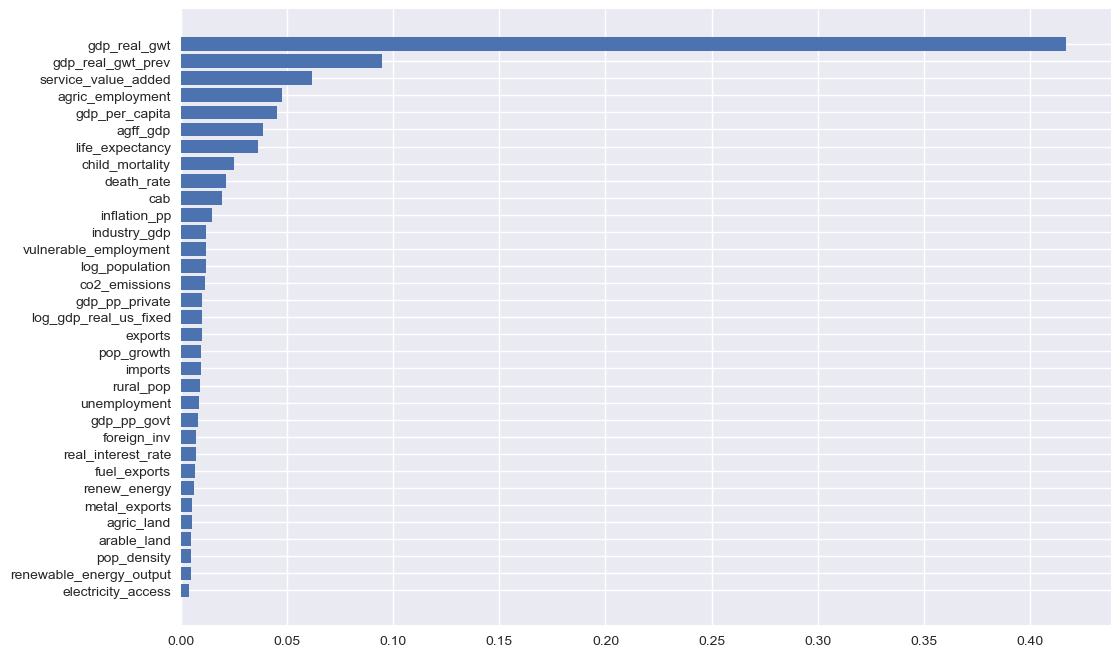

In [43]:
# Plotting feature importance

plt.rcParams['figure.figsize'] = [12, 8]
sorted_idx = rf_regressor.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], rf_regressor.feature_importances_[sorted_idx])

In [44]:
# plotting permutation importance

perm_importance_rf = permutation_importance(rf_regressor, x_train, y_train)
sorted_idx_rf = perm_importance_rf.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

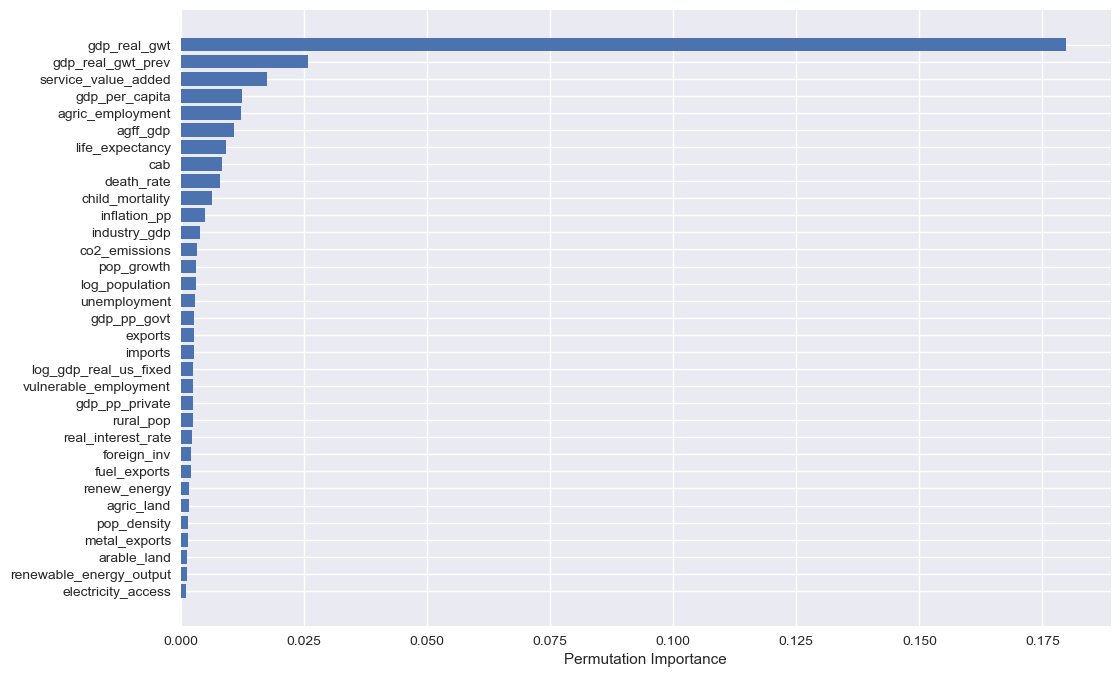

In [45]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.barh(x_train.columns[sorted_idx_rf], perm_importance_rf.importances_mean[sorted_idx_rf])
plt.xlabel("Permutation Importance")

### Support Vector Regression (SVR):

Two gridsearchs - with the latter involving a tighter gridsearch - are involved for hyperparameter tuning

In [28]:
svr_regressor = SVR(kernel = 'rbf')

In [29]:
svr_regressor.get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [30]:
from datetime import datetime
startTime = datetime.now()

svr_regressor = SVR(kernel = 'rbf', n_jobs = 3)

gamma = np.arange(0.0025, 0.01, 0.0025)
tol = np.arange(0.1, 0.15, 0.01)
C_list = np.arange(0.0025, 0.02, 0.0025)
epsilon = np.arange(0.005, 0.02, 0.005)


# Create the random grid
param_grid = {'kernel':['rbf'],
              'gamma': gamma,
               'tol': tol,
               'C': C_list,
               'epsilon': epsilon}

svr_grid = GridSearchCV(estimator = svr_regressor,
                                param_grid = param_grid,
                                scoring='neg_mean_absolute_error',
                                cv = tscv)
svr_grid.fit(x_train.values, y_train.values, sample_weight= ml_weights)

print(datetime.now() - startTime)

0:24:46.883043


In [31]:
print('MAE: %.3f' % svr_grid.best_score_)
print('Config: %s' % svr_grid.best_params_)

MAE: -0.587
Config: {'C': 0.02, 'epsilon': 0.01, 'gamma': 0.0075, 'kernel': 'rbf', 'tol': 0.13}


In [48]:
from datetime import datetime
startTime = datetime.now()

svr_regressor = SVR(kernel = 'rbf')

gamma = np.arange(0.005, 0.01, 0.001)
tol = np.arange(0.1, 0.15, 0.01)
C_list = np.arange(0.01, 0.05, 0.005)
epsilon = np.arange(0.005, 0.02, 0.005)


# Create the random grid
param_grid = {'gamma': gamma,
               'tol': tol,
               'C': C_list,
               'epsilon': epsilon}

svr_grid = GridSearchCV(estimator = svr_regressor,
                                param_grid = param_grid,
                                scoring='neg_mean_absolute_error',
                                cv = tscv)
svr_grid.fit(x_train.values, y_train.values, sample_weight= ml_weights)

print(datetime.now() - startTime)

0:48:23.935966


In [49]:
print('MAE: %.3f' % svr_grid.best_score_)
print('Config: %s' % svr_grid.best_params_)

MAE: -0.582
Config: {'C': 0.045, 'epsilon': 0.01, 'gamma': 0.009000000000000001, 'tol': 0.13}


In [55]:
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.set_params(**svr_grid.best_params_)

SVR(C=0.045, epsilon=0.01, gamma=0.009000000000000001, tol=0.13)

In [56]:
svr_regressor.fit(x_train, y_train, sample_weight= ml_weights)
y_model = svr_regressor.predict(x_train)  

In [57]:
cross_val_score(svr_regressor, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.6028443542198881

In [58]:
cross_val_score(svr_regressor, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8350795596207671

In [59]:
perm_importance_svr = permutation_importance(svr_regressor, x_train, y_train)

feature_names_svr = x_train.columns
features_svr = np.array(feature_names_svr)

sorted_idx_svr = perm_importance_svr.importances_mean.argsort()

Text(0.5, 0, 'Permutation Importance')

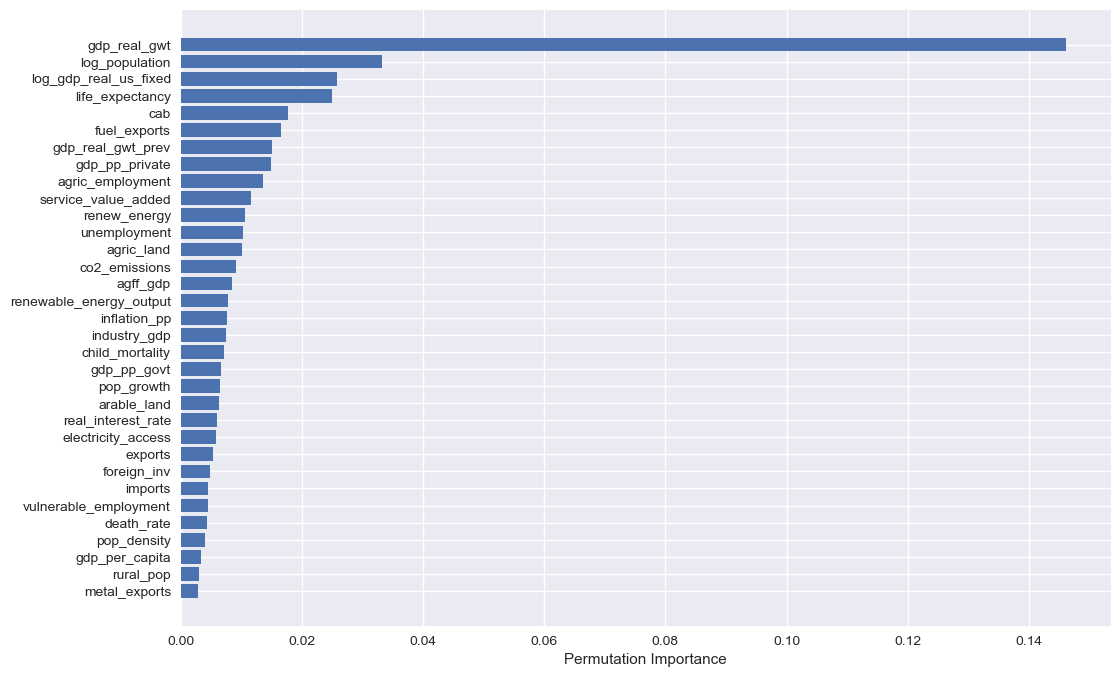

In [60]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.barh(features_svr[sorted_idx_svr], perm_importance_svr.importances_mean[sorted_idx_svr])
plt.xlabel("Permutation Importance")

### K-Nearest Neighbors Regression:

For this algorithm, weighted KNN is considered (with Minkowski distance); the weights to be assigned are the correlation between (next year's) GDP growth and the respective covariates

In [61]:
knn_regression = KNeighborsRegressor()

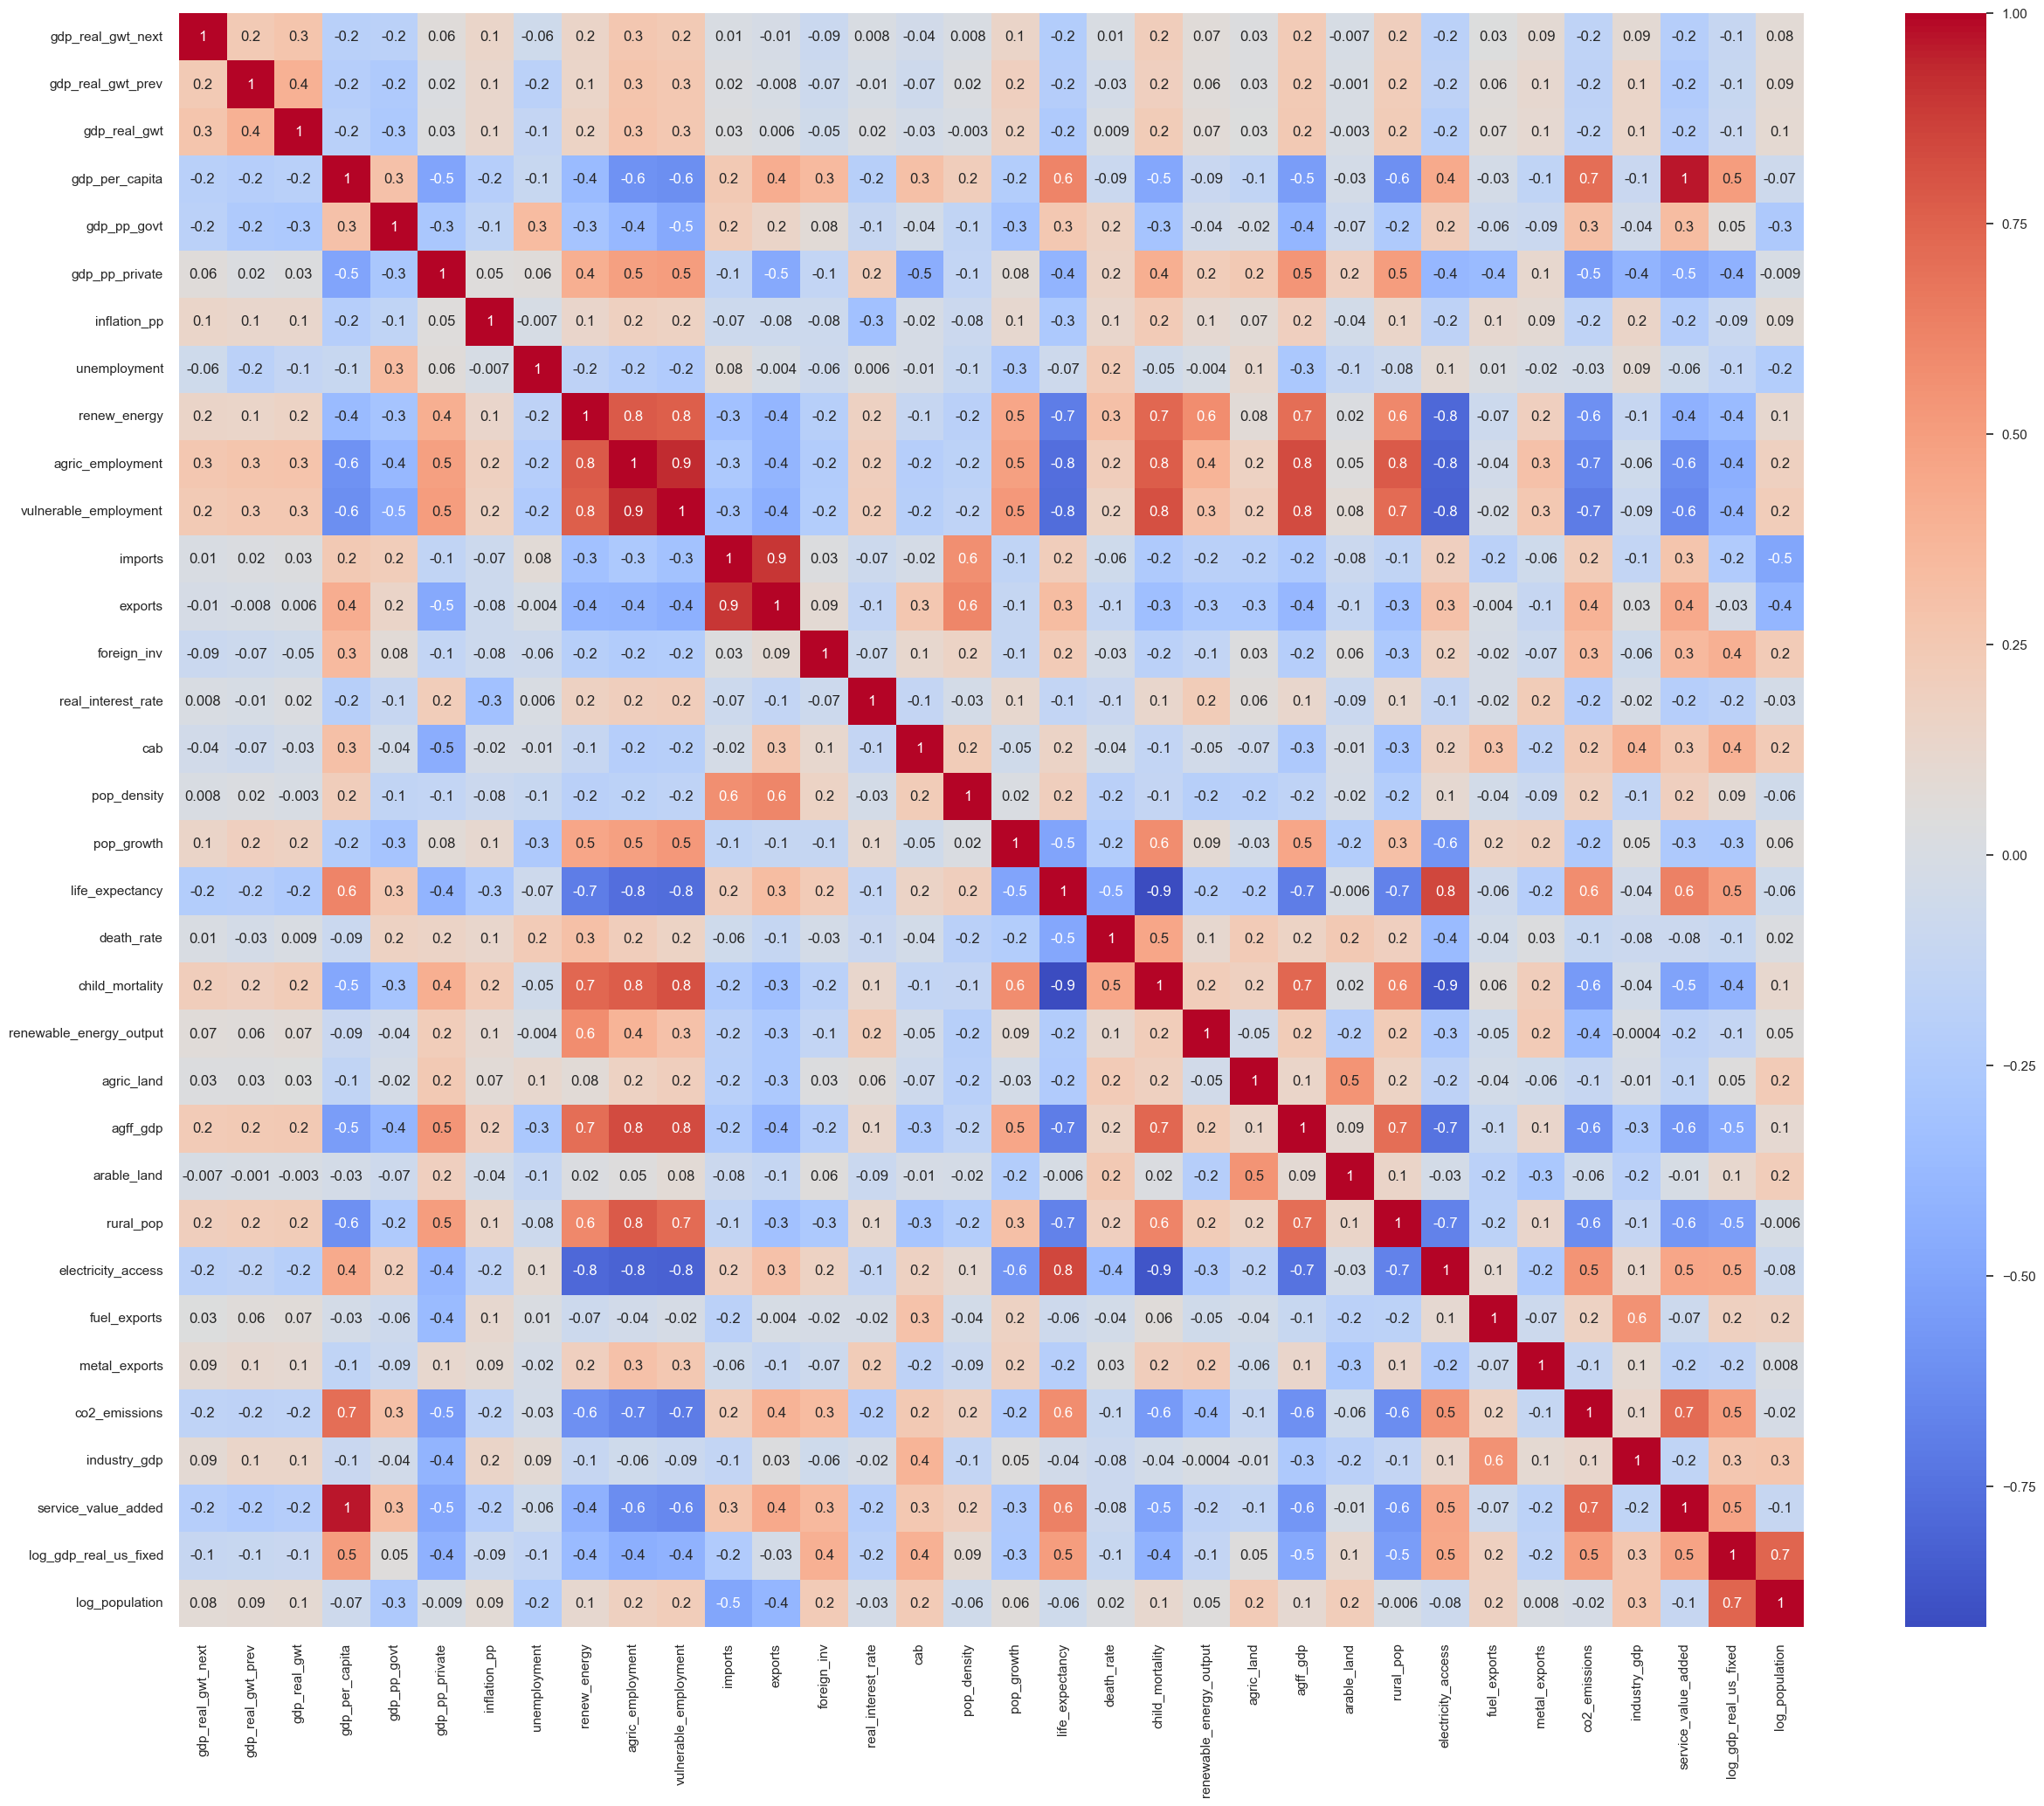

In [62]:
sns.set(rc = {'figure.figsize' : (30, 24)})
corr = pd.concat([y_train, x_train], axis = 1).corr()
corr_map = sns.heatmap(corr, annot = True, 
                       fmt = ".1g", cmap = "coolwarm")

In [63]:
corr = pd.concat([y_train, x_train], axis = 1).corr()
w_knn = corr.gdp_real_gwt_next[1:]
w_knn = abs(w_knn)

neighbors = np.arange(1, 50, 1)
scores = []
for k in neighbors:
    clf = KNeighborsRegressor(n_neighbors = k,  weights = 'distance', metric='wminkowski', p=1, metric_params={'w': w_knn})
    clf.fit(x_train, y_train)
    score = cross_val_score(clf, x_train, y_train, cv = tscv, scoring='neg_mean_absolute_error')
    scores.append(score.mean())

Text(0, 0.5, 'MAE')

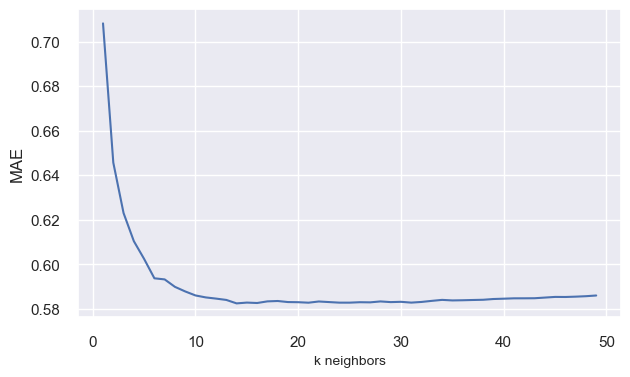

In [64]:
plt.rcParams['figure.figsize'] = [7, 4]
plt.plot(neighbors,[-x for x in scores])
plt.xlabel('k neighbors', fontsize=10)
plt.ylabel('MAE', fontsize=12)

In [67]:
num_knn = neighbors[np.argmax(scores)]
print(num_knn)

14


In [68]:
corr = pd.concat([y_train, x_train], axis = 1).corr()
w_knn = corr.gdp_real_gwt_next[1:]
w_knn = abs(w_knn)
knn_regression = KNeighborsRegressor(n_neighbors = num_knn,
                                     weights = 'distance',
                                     metric = 'wminkowski',
                                     metric_params={'w': w_knn},
                                     p=1,
                                     n_jobs = -1)

knn_regression.fit(x_train, y_train)

KNeighborsRegressor(metric='wminkowski',
                    metric_params={'w': gdp_real_gwt_prev        0.238993
gdp_real_gwt             0.274066
gdp_per_capita           0.197046
gdp_pp_govt              0.176788
gdp_pp_private           0.059513
                           ...   
co2_emissions            0.160270
industry_gdp             0.087787
service_value_added      0.209546
log_gdp_real_us_fixed    0.112100
log_population           0.081702
Name: gdp_real_gwt_next, Length: 33, dtype: float64},
                    n_jobs=-1, n_neighbors=14, p=1, weights='distance')

In [69]:
cross_val_score(knn_regression, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5825159152724921

In [70]:
cross_val_score(knn_regression, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8126930749230058

### Boosted trees regression:

For this algorithm, we implement XGBoost

As for hyperparameter tuning, Bayesian Optimization is implemented - an algorithm that involves a probabilistic model plsu iterative updating of posterior distributions from the prior

It is suitable for black box models with high computational cost, although decreases its performance exponentially as the dimensionality of hyperparameters increases - just as any other algorithm for tuning hyperparameters

In [71]:
xgb_model = xgb.XGBRegressor(n_jobs = -1, random_state = 777)

In [72]:
# Bayesian optimization

pbounds = {
    'learning_rate': (-4,-1),
    'n_estimators': (500, 2000),
    'max_depth': (10,30),
    'subsample': (0.6, 0.8),  # Change for big datasets
    'colsample_bytree': (0.5, 0.75),  # Change for datasets with lots of features
    'gamma': (0.5, 1.5),
    'reg_lambda': (0,1),
    'reg_alpha': (0,1)}

def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample_bytree,
                        gamma,
                       reg_lambda,
                       reg_alpha):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = xgb.XGBRegressor(
        max_depth=max_depth,
        learning_rate=pow(10,learning_rate),
        n_estimators=n_estimators,
        gamma=gamma,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    return np.mean(cross_val_score(clf, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error'))

xgb_optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=777,
)

xgb_optimizer.maximize(init_points=10, n_iter=25)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------
| 1         | -0.7088   | 0.5382    | 0.8024    | -3.814    | 19.2      | 1.753e+03 | 0.927     | 0.727     | 0.7537    |
| 2         | -0.7093   | 0.5673    | 1.144     | -3.72     | 11.59     | 1.384e+03 | 0.3433    | 0.9889    | 0.7253    |
| 3         | -0.6504   | 0.6704    | 1.052     | -3.193    | 17.47     | 834.4     | 0.1864    | 0.3906    | 0.6386    |
| 4         | -0.5839   | 0.6527    | 1.383     | -2.133    | 15.06     | 769.9     | 0.8164    | 0.2254    | 0.7034    |
| 5         | -0.5828   | 0.6296    | 1.1       | -2.402    | 10.27     | 1.286e+03 | 0.8959    | 0.7699    | 0.6246    |
| 6         | -0.5881   | 0.574     | 1.112     | -1.822    | 19.27     | 1.654e+03 | 0.1916    | 0.5579    | 0.7102    |
| 7         | -0.7167   

In [191]:
xgb_optimizer.max['params']

{'colsample_bytree': 0.5120739489120882,
 'gamma': 0.5952844636667254,
 'learning_rate': -2.653255556491361,
 'max_depth': 17.73220244793113,
 'n_estimators': 1016.0967814820892,
 'reg_alpha': 0.10047550871053534,
 'reg_lambda': 0.06308989230019313,
 'subsample': 0.7472019447132114}

In [105]:
[xgb_optimizer.max['params']]

[{'colsample_bytree': 0.6055703131543715,
  'gamma': 1.3182280819445018,
  'learning_rate': -2.505117201107554,
  'max_depth': 29.028508901897215,
  'n_estimators': 564.3893322129462,
  'reg_alpha': 0.44170272235978214,
  'reg_lambda': 0.4261443798741591,
  'subsample': 0.7873335579364567}]

In [114]:
xgb_optimizer.max['params']['max_depth']

29.028508901897215

In [118]:
xgb_model = xgb.XGBRegressor(booster='gbtree', min_child_weight=1, n_jobs = 3, random_state = 777)
xgb_model.set_params(
        max_depth=round(xgb_optimizer.max['params']['max_depth']),
        learning_rate=pow(10,xgb_optimizer.max['params']['learning_rate']),
        n_estimators=round(xgb_optimizer.max['params']['n_estimators']),
        gamma=xgb_optimizer.max['params']['gamma'],
        reg_lambda=xgb_optimizer.max['params']['reg_lambda'],
        reg_alpha=xgb_optimizer.max['params']['reg_alpha'],
        subsample=xgb_optimizer.max['params']['subsample'],
        colsample_bytree=xgb_optimizer.max['params']['colsample_bytree']
    )

XGBRegressor(base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.6055703131543715,
             enable_categorical=False, gamma=1.3182280819445018, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.003125235859902059, max_delta_step=None,
             max_depth=29, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=564, n_jobs=3,
             num_parallel_tree=None, predictor=None, random_state=777,
             reg_alpha=0.44170272235978214, reg_lambda=0.4261443798741591,
             scale_pos_weight=None, subsample=0.7873335579364567,
             tree_method=None, validate_parameters=None, verbosity=None)

In [119]:
xgb_model.fit(x_train.values, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6055703131543715,
             enable_categorical=False, gamma=1.3182280819445018, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.003125235859902059, max_delta_step=0, max_depth=29,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=564, n_jobs=3, num_parallel_tree=1, predictor='auto',
             random_state=777, reg_alpha=0.44170272235978214,
             reg_lambda=0.4261443798741591, scale_pos_weight=1,
             subsample=0.7873335579364567, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [120]:
y_model = xgb_model.predict(x_train)  

In [121]:
cross_val_score(xgb_model, x_train, y_train, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.5758290809706922

In [122]:
cross_val_score(xgb_model, x_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.801304055077647

<BarContainer object of 33 artists>

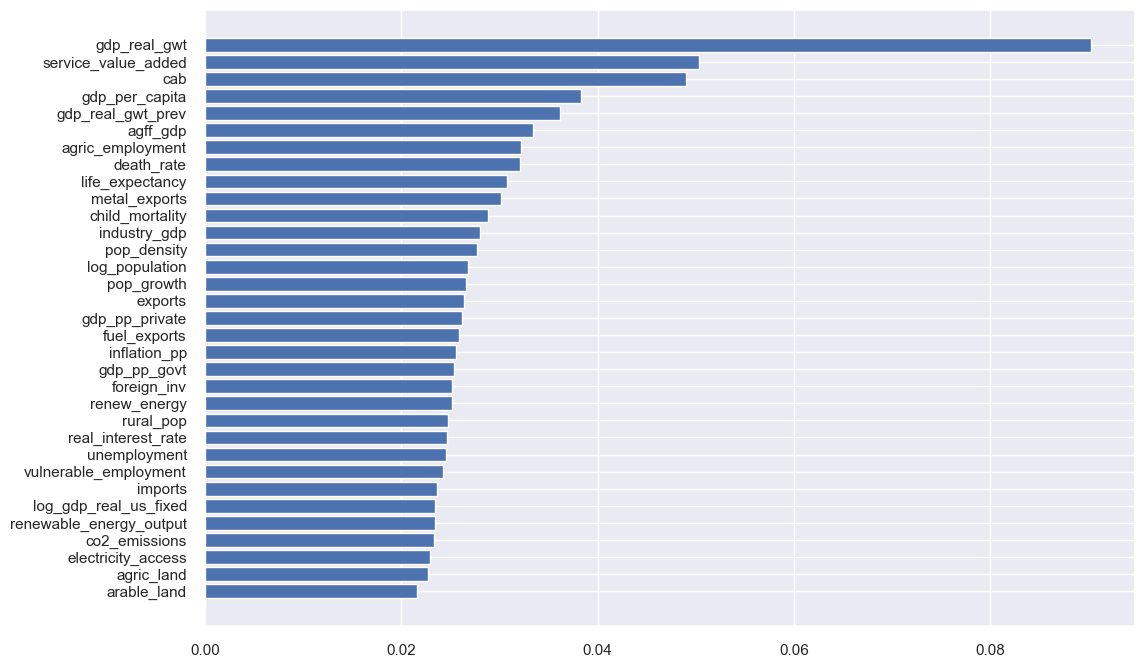

In [123]:
plt.rcParams['figure.figsize'] = [12, 8]
sorted_idx = xgb_model.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])

### Artificial Neural Networks (ANN) regression:

In this case, an arbitrary structure with two hidden layers plus two dropout layers is defined; addition of extra layers can be defined for hyperparameter tuning as well, although it is not done in this case for simplicity

Bayesian optimization is performed as well; ideally one would benefit from more iterations, but due to CPU issues I am only illustrating a few

------------------
**Disclaimer:** the optimization takes time!

In [25]:
# creating early stopping and MSE for the neural network
es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
mse = MeanSquaredError()

---------------------------
**For illustration only**, below is the algorithm for tuning hyperparameters - I did not do it this time since I need a new PC

In [25]:
# Creating model using the Sequential in tensorflow
def build_model_using_sequential_1(neurons, learning_rate):
    #activationL = ['relu','sigmoid','tanh', 'softsign', 'selu']
    neurons = round(neurons)
    #activation1 = activationL[round(activation1)]
    lr = pow(10,learning_rate)
    # batch_size = round(batch_size)
    # epochs = round(epochs)
    def nn_cl_fun():
        model = Sequential([
            Dense(neurons, kernel_initializer='normal', activation='relu'),
            Dense(1)
        ])
        model.compile(loss=mse, optimizer=Adam(learning_rate=lr), metrics=[mse])
        return model
    #es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
    nn = KerasRegressor(build_fn=nn_cl_fun, epochs=100, batch_size=32, verbose=0)
    score = cross_val_score(nn, x_train.values, y_train.values,
                            scoring='neg_mean_absolute_error', cv=tscv, fit_params={'callbacks':[es]}).mean()
    return score

In [42]:
from datetime import datetime
startTime = datetime.now()

params_nn ={
    'neurons': (10, 60),
    'learning_rate':(-5,-1)
}
# Run Bayesian Optimization
nn_bo1 = BayesianOptimization(build_model_using_sequential_1, params_nn, random_state=777)
nn_bo1.maximize(init_points=10, n_iter=25)

|   iter    |  target   | learni... |  neurons  |
-------------------------------------------------
| 1         | -0.6094   | -4.389    | 25.12     |
| 2         | -0.6158   | -4.752    | 32.99     |
| 3         | -0.7479   | -1.659    | 56.35     |
| 4         | -0.7321   | -2.092    | 48.42     |
| 5         | -0.6062   | -3.923    | 42.2      |
| 6         | -0.6125   | -4.627    | 13.98     |
| 7         | -0.6847   | -2.642    | 27.17     |
| 8         | -0.6966   | -1.044    | 41.32     |
| 9         | -0.7075   | -2.273    | 37.61     |
| 10        | -0.6045   | -3.925    | 28.66     |
| 11        | -0.6114   | -3.705    | 40.61     |
| 12        | -0.6102   | -4.796    | 41.33     |
| 13        | -0.617    | -5.0      | 30.41     |
| 14        | -0.6998   | -2.49     | 31.14     |
| 15        | -0.6193   | -4.998    | 27.86     |
| 16        | -0.6237   | -4.902    | 23.04     |
| 17        | -0.6166   | -4.746    | 16.43     |



KeyboardInterrupt



In [ ]:
print(datetime.now() - startTime)

In [ ]:
nn_bo1.max['params']

In [26]:
# Creating model using the Sequential in tensorflow
def build_model_using_sequential_2(neurons, learning_rate):
    neurons = round(neurons)
    # batch_size = round(batch_size)
    # epochs = round(epochs)
    def nn_cl_fun():
        model = Sequential([
            Dense(neurons, kernel_initializer='normal', activation='relu'),
            Dense(neurons, activation='relu'),
            Dense(1)
        ])
        mse = MeanSquaredError()
        lr = pow(10,learning_rate)
        model.compile(
            loss=mse, 
            optimizer=Adam(learning_rate=lr), 
            metrics=[mse]
        )
        return model
    es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
    nn = KerasRegressor(build_fn=nn_cl_fun, epochs=100, batch_size=32, verbose=0)
    score = cross_val_score(nn, x_train.values, y_train.values,
                            scoring='neg_mean_absolute_error', cv=tscv, fit_params={'callbacks':[es]}).mean()
    return score

In [ ]:
from datetime import datetime
startTime = datetime.now()

params_nn ={
    'neurons': (10, 60),
    'learning_rate':(-5,-1)
}
# Run Bayesian Optimization
nn_bo2 = BayesianOptimization(build_model_using_sequential_2, params_nn, random_state=777)
nn_bo2.maximize(init_points=10, n_iter=25)

In [ ]:
from datetime import datetime
startTime = datetime.now()

params_nn ={
    'neurons': (10, 60),
    'learning_rate':(-5,-1)
}
# Run Bayesian Optimization
nn_bo2 = BayesianOptimization(build_model_using_sequential_2, params_nn, random_state=777)
nn_bo2.maximize(init_points=10, n_iter=25)

In [ ]:
print(datetime.now() - startTime)

In [ ]:
nn_bo2.max['params']

------------------------
Below I am displaying two neural networks, with one and two hidden layers respectively

Due to low performance, this algorithm is left out of the next phase. It is definitely a good extension of this problem to build a more complex and fine-tuned neural network - potentially attempting *recurrent neural networks* due to their short memory advantage that would deal with time series more properly.

When I have more free time in the future, I will attempt building a RNN for this problem :)

--------------------

In [26]:
hidden_units1 = 50
# hidden_units2 = 50
learning_rate = 0.0001
# Creating model using the Sequential in tensorflow
def build_model_using_sequential1():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
        Dense(1)
    ])
    mse = MeanSquaredError()
    model.compile(loss=mse, optimizer=Adam(learning_rate=learning_rate), metrics=[mse])
    return model

In [27]:
es = EarlyStopping(monitor='mean_squared_error', mode='min', verbose=0, patience=20)
ann_model1 = KerasRegressor(build_fn=build_model_using_sequential1, epochs=100, batch_size=32, verbose=0)
ann_model1.fit(np.asarray(x_train), np.asarray(y_train), verbose=0, callbacks=[es])

In [28]:
cross_val_score(ann_model1, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.6037064384225349

In [29]:
cross_val_score(ann_model1, x_train.values, y_train.values, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8362853105008327

In [30]:
hidden_units1 = 50
hidden_units2 = 50
learning_rate = 0.0001
# Creating model using the Sequential in tensorflow
def build_model_using_sequential2():
    model = Sequential([
        Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
        Dense(hidden_units2, activation='relu'),
        Dense(1)
    ])
    mse = MeanSquaredError()
    model.compile(loss=mse, optimizer=Adam(learning_rate=learning_rate), metrics=[mse])
    return model

In [31]:
ann_model2 = KerasRegressor(build_fn=build_model_using_sequential2, epochs=100, batch_size=32, verbose=0)
ann_model2.fit(np.asarray(x_train), np.asarray(y_train), verbose=0, callbacks=[es])

In [32]:
cross_val_score(ann_model2, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean()

-0.6108781430668188

In [33]:
cross_val_score(ann_model2, x_train.values, y_train.values, cv=tscv, scoring='neg_root_mean_squared_error').mean()

-0.8590914089305282

In [60]:
# displaying the structure of the neural network

shape_width, shape_height = x_train.shape[0], x_train.shape[1]
input_shape = (shape_width, shape_height, 1)

mse = MeanSquaredError()
ann_plot = Sequential()
ann_plot.add(Dense(hidden_units1, kernel_initializer='normal', activation='relu', input_shape=input_shape))
ann_plot.add(Dense(hidden_units2, activation='relu'))
ann_plot.add(Dense(1, activation='linear'))
ann_plot.compile(loss=mse, optimizer=Adamax(lr=0.0001), metrics=[mse])

plot_model(ann_plot, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=72) #rankdir='LR'

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [26]:
ann_plot.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1480, 34, 22)      44        
                                                                 
 dropout_2 (Dropout)         (None, 1480, 34, 22)      0         
                                                                 
 dense_4 (Dense)             (None, 1480, 34, 9)       207       
                                                                 
 dropout_3 (Dropout)         (None, 1480, 34, 9)       0         
                                                                 
 dense_5 (Dense)             (None, 1480, 34, 1)       10        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


## Forecast combination

Research shows benefit in performing forecast combination for prediction of GDP growth

Following weights are evaluated:
* Equal weights
* Inverse MAE weights
* Inverse MSE weights
* LS weights (explained later)


Due to low performance and higher computational cost, **neural networks were left out of this stage**.
In a future edition, a RNN will be attempted.

In [36]:
# TRAINING MODELS AGAIN (not necessary to run again, just if you're running the script from this point):


# Random Forest
rf_optim = {'bootstrap': True, 'criterion': 'mse',
            'max_depth': 10, 'max_features': 0.3333333333333333,
            'min_samples_leaf': 0.02, 'min_samples_split': 0.02,
            'n_estimators': 1500, 'random_state': 777}

rf_regressor = RandomForestRegressor().set_params(**rf_optim)


# XGBoost
xgb_optimizer = {'colsample_bytree': 0.6055703131543715,
  'gamma': 1.3182280819445018,
  'learning_rate': -2.505117201107554,
  'max_depth': 29.028508901897215,
  'n_estimators': 564.3893322129462,
  'reg_alpha': 0.44170272235978214,
  'reg_lambda': 0.4261443798741591,
  'subsample': 0.7873335579364567}
xgb_model = xgb.XGBRegressor(booster='gbtree', min_child_weight=1, n_jobs = 3, random_state = 777)
xgb_model.set_params(
        max_depth=round(xgb_optimizer['max_depth']),
        learning_rate=pow(10,xgb_optimizer['learning_rate']),
        n_estimators=round(xgb_optimizer['n_estimators']),
        gamma=xgb_optimizer['gamma'],
        reg_lambda=xgb_optimizer['reg_lambda'],
        reg_alpha=xgb_optimizer['reg_alpha'],
        subsample=xgb_optimizer['subsample'],
        colsample_bytree=xgb_optimizer['colsample_bytree']
    )



# SVR
svr_optim = {'C': 0.045, 'epsilon': 0.01, 'gamma': 0.009000000000000001, 'tol': 0.13}
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.set_params(**svr_optim)


# KNN regression
num_knn = 14
corr = pd.concat([y_train, x_train], axis = 1).corr()
w_knn = corr.gdp_real_gwt_next[1:]
w_knn = abs(w_knn)
knn_regression = KNeighborsRegressor(n_neighbors = num_knn,
                                     weights = 'distance',
                                     metric = 'wminkowski',
                                     metric_params={'w': w_knn},
                                     p=1,
                                     n_jobs = -1)

In [37]:
def rescaling_y(y_predict, y_input=gdp_df_final.gdp_real_gwt_next):
    scaler_y = StandardScaler()
    scaler_y.fit(np.array(y_input).reshape(-1,1))
    return scaler_y.inverse_transform(y_predict)

In [38]:
# function for combining forecasts
def forecast_list(x_model, list_models=[], index_list = []):
    return pd.DataFrame([x.predict(x_model) for x in list_models], index=index_list)

def forecast_combination(forecast_list, weights):
    w = weights/sum(weights)
    return forecast_list.multiply(w, axis='rows').sum()

# function for combining forecasts
def forecast_fit_predict(x_train, y_train, x_predict, models, weights):
    for model in models:
        model.fit(x_train.values, y_train.values)
    df_combine = pd.DataFrame([x.predict(x_predict) for x in models], index=np.array(list(range(0,len(models)))))
    return forecast_combination(df_combine, weights)

In [43]:
list_models = [rf_regressor, xgb_model, svr_regressor, knn_regression]
index_list = ['rf_regressor', 'xgb_model','svr_regressor', 'knn_regression']

--------------------------
First, individual model performance is displayed:

In [ ]:
for model in list_models:
    model.fit(x_train.values, y_train.values)

In [103]:
# individual performance of each ML algorithm (MAE)
for model in list_models:
    print(str(model.__class__) + ' MAE: ' + str(-cross_val_score(model, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean()) )

<class 'sklearn.ensemble._forest.RandomForestRegressor'> MAE: 0.5703072195507737
<class 'xgboost.sklearn.XGBRegressor'> MAE: 0.5758290809706922
<class 'sklearn.svm._classes.SVR'> MAE: 0.6028443542198881
<class 'sklearn.neighbors._regression.KNeighborsRegressor'> MAE: 0.5825159152724921


In [105]:
# individual performance (MSE)
for model in list_models:
    print(str(model.__class__) + ' MAE: ' + str(-cross_val_score(model, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_squared_error').mean()) )

<class 'sklearn.ensemble._forest.RandomForestRegressor'> MAE: 0.868094464248584
<class 'xgboost.sklearn.XGBRegressor'> MAE: 0.8738661531942183
<class 'sklearn.svm._classes.SVR'> MAE: 0.9193864877049321
<class 'sklearn.neighbors._regression.KNeighborsRegressor'> MAE: 0.8797098071578432


--------------------------
We define weights for combination:
* Equal weights
* Inverse MAE
* Inverse MSE

In [51]:
# weights for combination: first three
w_equal = np.repeat(1,len(list_models))
w_inv_mae = np.reciprocal(
    [-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_absolute_error').mean() for x in list_models])
w_inv_mse = np.reciprocal(
    [-cross_val_score(x, x_train.values, y_train.values, cv=tscv, scoring='neg_mean_squared_error').mean() for x in list_models])

-------------------
We then create a dataframe with all forecasts of each country and year (**walk forward**)

In [52]:
n_0 = int(len(gdp_df_final)/int(len(gdp_df_final) / len(gdp_df_final.ISO3.unique())))
n_f = len(gdp_df_final)

In [53]:
# dataframe used for forecast combination evaluation (considers the second year onwards' forecasts)
forecasts_tscv = pd.DataFrame(columns=list(range(n_0,n_f)))
y_model = pd.Series(index=forecasts_tscv.columns)
for model in list_models:
    for train_index, test_index in tscv.split(y_train):
        model.fit(x_train.iloc[train_index,:].values, y_train[train_index].values)
        y_model[test_index] = model.predict(x_train.iloc[test_index,:].values)
    forecasts_tscv = forecasts_tscv.append(y_model, ignore_index=True)
forecasts_tscv.index = index_list
forecasts_tscv

,139,140,141,142,143,144,145,146,147,148,...,2770,2771,2772,2773,2774,2775,2776,2777,2778,2779
rf_regressor,1.465260,0.168332,-0.996187,1.050022,-0.621168,-0.264149,-0.491467,1.109479,-0.069755,-0.589222,...,-0.568405,-0.506072,0.159976,0.227839,-0.749768,-0.727664,0.023824,-0.224792,-0.468625,-0.069574
xgb_model,1.596282,0.168225,-0.392222,1.045353,-0.291499,-0.087309,-0.226510,1.016087,-0.093175,-0.246783,...,-0.386317,-0.195362,0.172641,0.282327,-0.713244,-0.384064,0.005845,-0.229655,-0.141295,-0.196646
svr_regressor,0.047854,0.023730,-0.116813,0.078860,-0.168997,-0.205618,-0.205538,0.077753,0.114668,-0.221209,...,-0.704115,-0.198366,0.284010,0.330448,-0.635755,-0.558351,0.161376,-0.304372,-0.522712,0.051062
knn_regression,0.552771,0.199382,-0.824683,0.646168,-0.387879,-0.320398,-0.481417,0.696510,0.003219,-0.469726,...,-0.582250,-0.262531,0.185282,0.299374,-0.654727,-0.392555,0.449513,-0.509791,-0.679140,-0.337297


In [54]:
forecasts_tscv.transpose()

,rf_regressor,xgb_model,svr_regressor,knn_regression
139,1.465260,1.596282,0.047854,0.552771
140,0.168332,0.168225,0.023730,0.199382
141,-0.996187,-0.392222,-0.116813,-0.824683
142,1.050022,1.045353,0.078860,0.646168
143,-0.621168,-0.291499,-0.168997,-0.387879
...,...,...,...,...
2775,-0.727664,-0.384064,-0.558351,-0.392555
2776,0.023824,0.005845,0.161376,0.449513
2777,-0.224792,-0.229655,-0.304372,-0.509791
2778,-0.468625,-0.141295,-0.522712,-0.679140


### Performance with equal weights, inverse MAE and inverse MSE:

In [55]:
# MAE and MSE: equal weights
print('MAE equal weigths: ' + str(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_equal[[0,2]]))))
print('MSE equal weigths: ' + str(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_equal[[0,2]])))))

MAE equal weigths: 0.5765451571888104
MSE equal weigths: 0.9367066420378686


In [56]:
# MAE and MSE: inverse MAE weights
print('MAE inverse-MAE weigths: ' + str(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mae[[0,2]]))))
print('MSE inverse-MAE weigths: ' + str(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mae[[0,2]])))))

MAE inverse-MAE weigths: 0.5760626526216963
MSE inverse-MAE weigths: 0.9363335946913744


In [57]:
# MAE and MSE: inverse MSE weights
print('MAE inverse-MSE weigths: ' + str(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mse[[0,2]]))))
print('MSE inverse-MSE weigths: ' + str(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_inv_mse[[0,2]])))))

MAE inverse-MSE weigths: 0.5760460430817054
MSE inverse-MSE weigths: 0.9363209152045595


#### Performance with least squares wights approach:
This approach consists of assigning weights according to the coefficients of a simple OLS linear regression; any problems of heteroscedasticity, collinearity, etcetera, are ignored - the purpose is to assign weights!

In [61]:
# LS weights with all algorithms
reg_ls = LinearRegression(fit_intercept=True, normalize=False)
reg_ls.fit(forecasts_tscv.transpose(), y_train[n_0:])
w_ls = reg_ls.coef_
reg_ls.coef_

array([ 0.52215482,  0.46545744, -0.55548464,  0.23745432])

In [62]:
print('MAE (LS weigths and all models):' + str(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv, w_ls))))
print('MSE (LS weigths and all models):' + str(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv, w_ls)))))

MAE (LS weigths and all models):0.5877366375339172
MSE (LS weigths and all models):0.9449795385215309


In [63]:
# LS weights with all but random forest
reg_ls_nonrf = LinearRegression(fit_intercept=True, normalize=False)
reg_ls_nonrf.fit(forecasts_tscv.transpose().iloc[:,1:], y_train[n_0:])
w_ls_nonrf = reg_ls_nonrf.coef_
reg_ls_nonrf.coef_

array([ 0.82033588, -0.36635244,  0.32171105])

In [64]:
print('MAE (LS weigths and all except RF):' + str(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[1:,:], w_ls_nonrf))))
print('MAE (LS weigths and all except RF):' + str(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[1:,:], w_ls_nonrf)))))

MAE (LS weigths and all except RF):0.5757627506847613
MAE (LS weigths and all except RF):0.935919792332353


In [65]:
# LS weights with only RF and SVR (research based approach)
reg_ls_rf_svm = LinearRegression(fit_intercept=True, normalize=False)
reg_ls_rf_svm.fit(forecasts_tscv.transpose().iloc[:,[0,2]], y_train[n_0:])
w_ls_rf_svm = reg_ls_rf_svm.coef_
reg_ls_rf_svm.coef_

array([ 1.09139451, -0.48627914])

In [66]:
print('MAE (LS weigths and RF+SVR):' + str(mean_absolute_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_ls_rf_svm))))
print('MAE (LS weigths and RF+SVR):' + str(sqrt(mean_squared_error(y_train[n_0:], forecast_combination(forecasts_tscv.iloc[[0,2],:], w_ls_rf_svm)))))

MAE (LS weigths and RF+SVR):0.6054954057818466
MAE (LS weigths and RF+SVR):0.9599476767878439


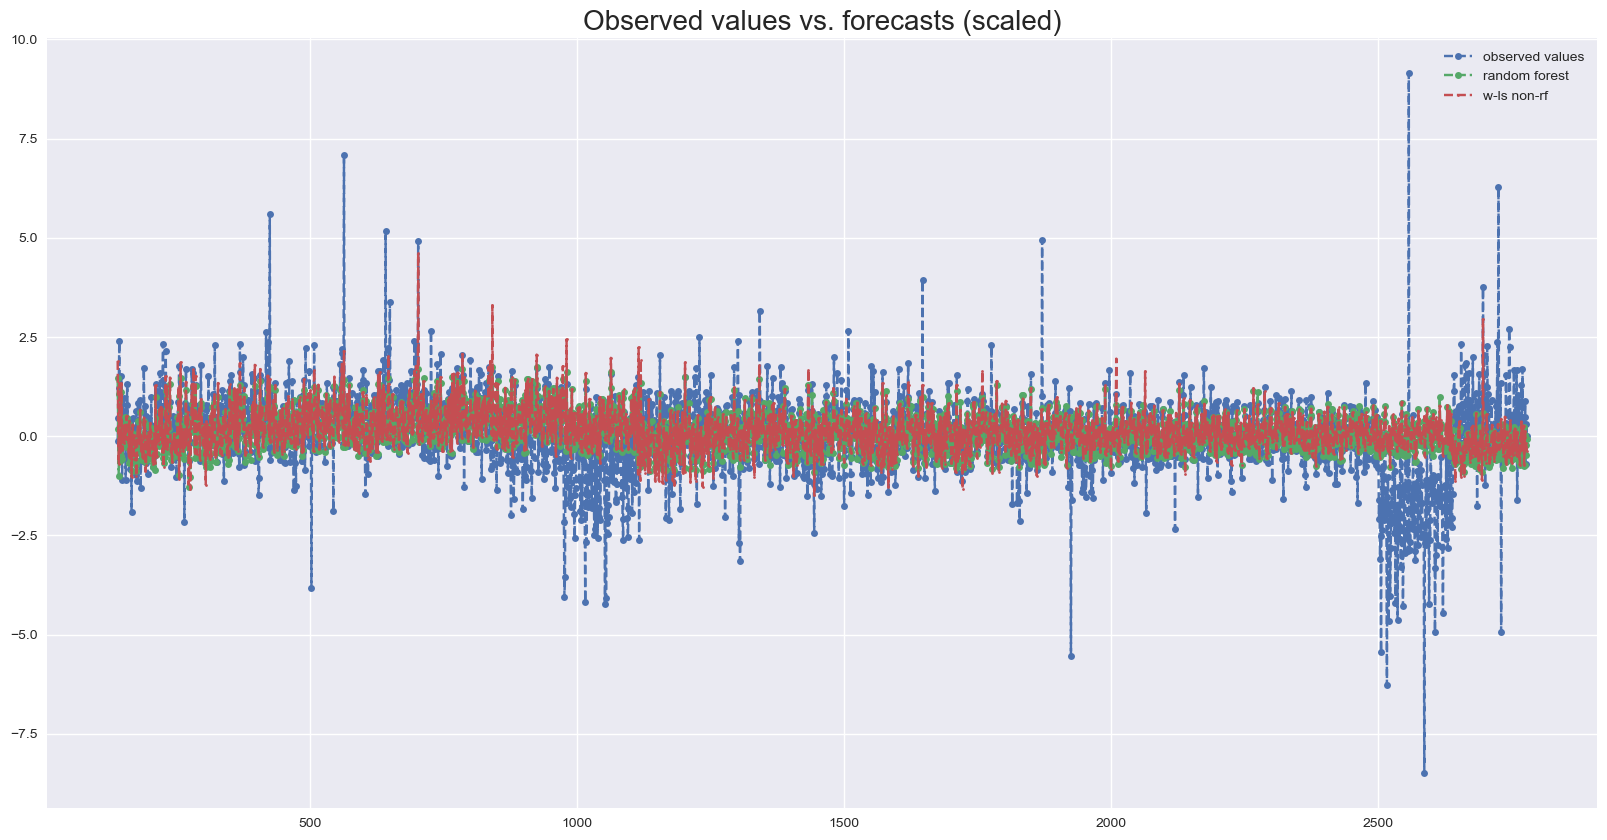

In [100]:
plt.rcParams['figure.figsize'] = [20, 10]
markersize=5
plt.plot(list(range(n_0,n_f)), y_train[n_0:], label = "observed values", linestyle="--",marker="o", markersize=markersize)
plt.plot(list(range(n_0,n_f)), forecasts_tscv.iloc[0,:], label = "random forest",linestyle="--",marker="o", markersize=5)
plt.plot(list(range(n_0,n_f)), forecast_combination(forecasts_tscv.iloc[1:,:], w_ls_nonrf), label = "w-ls non-rf",linestyle="--",marker="o", markersize=2)
plt.legend()
plt.title('Observed values vs. forecasts (scaled)', fontsize=20)
plt.show()

We can observe that the best performing algorithm is the Random Forest, outperforming forecast combination approaches

### Performance of benchmark:

**Spring report:** mean of MAE and MSE

In [97]:
errors_fc_1S[errors_fc_1S.year_fc >= errors_fc_1S.year_fc.min() + 1].mean()[1:]

mae    0.695471
mse    0.991457
dtype: float64

**Fall report:** mean of MAE and MSE

In [98]:
errors_fc_1F[errors_fc_1F.year_fc >= errors_fc_1F.year_fc.min() + 1].mean()

year_fc    2012.000000
mae           0.650367
mse           0.936417
dtype: float64

---------------

We observe that the **RF model** is the best performing model. The former, XGBoost and KNN all outperform in both MAE and MSE

We also observe that RF yields smoother and robust-to-outlier forecasts

Forecast combination does not present clear advantages of choosing exclusively RF in this project

The RF model presents its advantage in reducing variance - via its ensemble of decision trees and random feature inclusion - and in eliminating most problems induced by collinearity and nonlinearity